## Stability

In [1]:
# Set root directory of the project as the current working directory
import os
initial_dir = os.getcwd()  # Save initial directory (notebooks/)
os.chdir('..')  # Move to project/

In [2]:
# Other imports
import numpy as np
import shap

import logging
logging.basicConfig(level=logging.WARNING)

# Set the random seed for reproducibility
np.random.seed(42)

# Import Config from config.defaults and load_preprocessed_data, train_lstm_model, train_cnn_model from src.models
from config.defaults import Config
from src.models import load_saved_model, load_preprocessed_data
from src.stability import (calculate_relative_input_stability, 
                            calculate_relative_representation_stability, 
                            calculate_relative_output_stability)
from src.evaluation import evaluate_regression_model, evaluate_classification_model
# Load the default configuration
config = Config()
model_task = 'lstm_regression'

# Load preprocessed data
X_train, X_val, X_test, y_train_reg, y_val_reg, y_test_reg, metadata = load_preprocessed_data(model_task = model_task, eol_capacity=config.eol_capacity)

# Load saved LSTM model
lstm_model = load_saved_model(model_task, config)

In [3]:
evaluate_regression_model(lstm_model, X_test, y_test_reg, metadata["y_max"])

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0011 - mae: 0.0282  


(0.001062121824361384, 26.86453514391809)

In [6]:
lstm_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 120, 1)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 32)             │         4,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,693 (57.40 KB)

 Trainable params: 4,897 (19.13 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 9,796 (38.27 KB)

In [4]:
# Sample 50 random sequences from the train set
X_train_2d = X_train.reshape(X_train.shape[0], -1)
X_background = shap.sample(X_train_2d, 50)

# Reshape the test set to 2D
X_test_2d = X_test.reshape(X_test.shape[0], -1)

# extract one sequence from the test set
test_instance = shap.sample(X_test_2d, 1)

In [6]:
# RIS
ris_max, ris_mean = calculate_relative_input_stability(
    lstm_model, X_background, test_instance, noise_scale=0.1
)
print(f"RIS - Max: {ris_max:.4f}, Mean: {ris_mean:.4f}")

Input diffs: [1.14018086 1.03121432 1.07843374 1.05036322 1.28662305]
Value diffs: [0.49739055 0.25368112 0.37438845 0.42267595 0.37607198]
Ratios: [0.43623829 0.24600232 0.34715944 0.40240932 0.29229383]
RIS - Max: 0.4516, Mean: 0.3211


In [5]:
# RRS
rrs_max, rrs_mean = calculate_relative_representation_stability(
    lstm_model, test_instance, noise_scale=0.1, layer_name="lstm"
)
print(f"RRS - Max: {rrs_max:.4f}, Mean: {rrs_mean:.4f}")

Input diffs: [1.01312012 1.10729515 0.99337618 1.16559469 1.03182389]
Value diffs: [0.05205685 0.06066535 0.11238137 0.60768741 0.05397188]
Ratios: [0.0513827  0.05478697 0.11313073 0.52135397 0.05230726]
RRS - Max: 0.5214, Mean: 0.1706


In [8]:
# ROS
ros_max, ros_mean = calculate_relative_output_stability(
    lstm_model, test_instance, noise_scale=0.01
)
print(f"ROS - Max: {ros_max:.4f}, Mean: {ros_mean:.4f}")

Input diffs: [0.09989139 0.10856972 0.0994006  0.10499885 0.10906094]
Value diffs: [0.01695365 0.01668036 0.07643729 0.02333772 0.03272736]
Ratios: [0.16972081 0.15363731 0.76898222 0.22226646 0.30008324]
ROS - Max: 2.0407, Mean: 0.4447


## Global

In [9]:
global_test_instance = shap.sample(X_test_2d, 10) # 10 random samples from the test set

In [10]:
# Global RIS
ris_values = []
for i in range(global_test_instance.shape[0]):
    ris_max, ris_mean = calculate_relative_input_stability(
        lstm_model, X_background, global_test_instance[i:i+1], n_perturbations=20, noise_scale=0.1
    )
    ris_values.append(ris_mean)  # Collect mean RIS for each instance
global_ris_mean = np.mean(ris_values)
global_ris_max = np.max(ris_values)
print(f"Global RIS - Mean: {global_ris_mean:.4f}, Max: {global_ris_max:.4f}")

Input diffs: [1.11767955 1.24502701 1.02886701 1.20116064 1.04880621]
Value diffs: [0.31083553 0.22381322 0.47061802 0.26186448 0.30279894]
Ratios: [0.27810791 0.17976575 0.45741384 0.21800954 0.28870818]
Input diffs: [1.11777749 1.10828294 1.16733132 1.04792744 1.09437262]
Value diffs: [0.10456605 0.09438985 0.22693103 0.18491826 0.12858903]
Ratios: [0.09354818 0.08516765 0.19440156 0.17646094 0.11750022]
Input diffs: [0.99766896 1.08094892 1.06710654 1.10091836 1.11605771]
Value diffs: [0.09108575 0.15350798 0.09309477 0.14985041 0.32953334]
Ratios: [0.09129857 0.14201224 0.08724037 0.13611401 0.2952655 ]
Input diffs: [1.12942857 1.18075168 1.09263984 1.05423001 1.11991316]
Value diffs: [0.37271581 0.45187153 0.32571636 0.37023925 0.25508554]
Ratios: [0.33000388 0.38269819 0.29810039 0.351194   0.22777261]
Input diffs: [0.94595078 1.10491597 0.98976284 0.98137581 1.22082665]
Value diffs: [0.46821974 0.49432986 0.49515209 0.49309316 0.46554443]
Ratios: [0.49497262 0.44739136 0.5002734

In [11]:
# Global RRS
rrs_values = []
for i in range(global_test_instance.shape[0]):
    rrs_max, rrs_mean = calculate_relative_representation_stability(
        lstm_model, global_test_instance[i:i+1], noise_scale=0.1, layer_name="lstm"
    )
    rrs_values.append(rrs_mean)  # Collect mean RRS for each instance
global_rrs_mean = np.mean(rrs_values)
global_rrs_max = np.max(rrs_values)
print(f"Global RRS - Mean: {global_rrs_mean:.4f}, Max: {global_rrs_max:.4f}")

Input diffs: [1.1887315  1.14681767 1.21390049 1.20294554 1.01258612]
Value diffs: [0.10120568 0.05639018 0.17637578 0.12560715 0.47241464]
Ratios: [0.08513755 0.04917101 0.14529673 0.10441632 0.46654268]
Input diffs: [1.09786653 1.17413946 1.06485412 1.03716282 1.04448509]
Value diffs: [0.02864805 0.04491398 0.02330704 0.02604211 0.02043968]
Ratios: [0.0260943  0.03825268 0.02188754 0.02510899 0.01956915]
Input diffs: [1.17540547 0.95220878 1.16206093 1.07134558 1.06705923]
Value diffs: [0.03077552 0.04177838 0.04610085 0.07303858 0.03809875]
Ratios: [0.0261829  0.04387523 0.03967163 0.06817462 0.03570443]
Input diffs: [0.9945987  1.06927491 1.19346891 1.08153827 1.07396728]
Value diffs: [0.26342827 0.17491704 0.38065392 0.46122858 0.06716336]
Ratios: [0.26485885 0.16358472 0.31894749 0.42645609 0.06253763]
Input diffs: [1.20457784 1.06748922 0.99623858 1.09195186 1.07548679]
Value diffs: [0.22181326 0.24565317 0.4312835  0.45031872 0.54491192]
Ratios: [0.18414191 0.23012239 0.4329118

In [ ]:
# Global ROS
ros_values = []
for i in range(global_test_instance.shape[0]):
    ros_max, ros_mean = calculate_relative_output_stability(
        lstm_model, global_test_instance[i:i+1], n_perturbations=20, noise_scale=0.1
    )
    ros_values.append(ros_mean)  # Collect mean ROS for each instance
global_ros_mean = np.mean(ros_values)
global_ros_max = np.max(ros_values)
print(f"Global ROS - Mean: {global_ros_mean:.4f}, Max: {global_ros_max:.4f}")

Input diffs: [0.11837491 0.11617759 0.09744951 0.11172301 0.10100911]
Value diffs: [0.07466733 0.01750356 0.01493222 0.02530938 0.00204003]
Ratios: [0.63076995 0.1506621  0.15323027 0.2265369  0.02019648]
Input diffs: [0.1210551  0.1082736  0.10398619 0.10648161 0.10129266]
Value diffs: [0.00772291 0.00267419 0.00739193 0.00156619 0.00015458]
Ratios: [0.06379669 0.02469847 0.07108569 0.01470852 0.00152612]
Input diffs: [0.10111916 0.10732325 0.10808296 0.10806764 0.1123309 ]
Value diffs: [0.01506421 0.01256183 0.00065097 0.01073611 0.01326421]
Ratios: [0.14897484 0.11704666 0.00602289 0.09934618 0.11808157]
Input diffs: [0.10606648 0.11126982 0.1085583  0.10931437 0.09207107]
Value diffs: [0.05122739 0.09804016 0.01185226 0.0529846  0.09439963]
Ratios: [0.48297438 0.88110291 0.10917879 0.48469925 1.02529091]
Input diffs: [0.09717911 0.11853475 0.10391157 0.1119242  0.11779533]
Value diffs: [0.0449056  0.05144829 0.02839941 0.00866604 0.00128084]
Ratios: [0.46209111 0.43403546 0.2733036

## CNN

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7932 - loss: 0.6959  


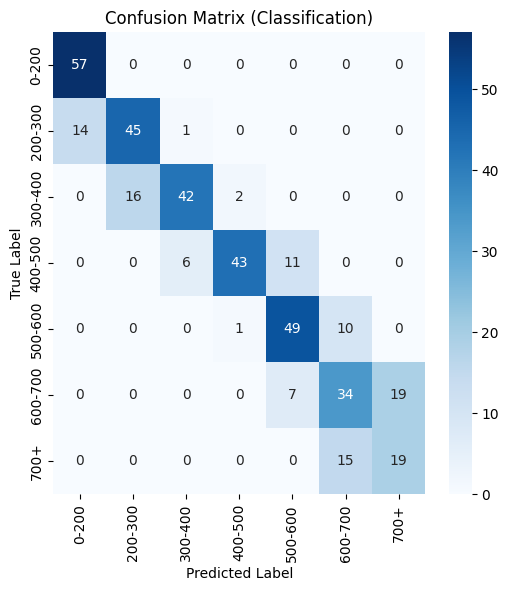

(0.7475209832191467,
 0.739130437374115,
 array([6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 5, 5, 5, 5,
        5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 4, 4, 4, 4, 4, 4, 4,
        4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
        4, 4, 4, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
        5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 4, 4, 4, 4, 4,
        4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 

In [3]:
model_task = 'cnn_classification'

# Load preprocessed data
X_train, X_val, X_test, y_train_reg, y_val_reg, y_test_reg, metadata = load_preprocessed_data(model_task = model_task, eol_capacity=config.eol_capacity)

# Load saved LSTM model
cnn_model = load_saved_model(model_task, config)

evaluate_classification_model(cnn_model, X_test, y_test_reg, config.labels)

### Local

In [6]:
# Sample 50 random sequences from the train set
X_train_2d = X_train.reshape(X_train.shape[0], -1)
X_background = shap.sample(X_train_2d, 50)

# Reshape the test set to 2D
X_test_2d = X_test.reshape(X_test.shape[0], -1)

# extract one sequence from the test set
test_instance = shap.sample(X_test_2d, 1)

In [7]:
# CNN RIS
ris_max, ris_mean = calculate_relative_input_stability(
    cnn_model, X_background, test_instance, noise_scale=0.1
)
print(f"CNN RIS - Max: {ris_max:.4f}, Mean: {ris_mean:.4f}")

Input diffs: [1.14018086 1.03121432 1.07843374 1.05036322 1.28662305]
Value diffs: [2.95908221 2.83022541 4.41511183 2.70128343 3.05484737]
Ratios: [2.59527441 2.74455596 4.09400379 2.57176125 2.37431419]
CNN RIS - Max: 4.0940, Mean: 2.8549


In [9]:
# CNN RRS (using last Conv1D layer)
rrs_max, rrs_mean = calculate_relative_representation_stability(
    cnn_model, test_instance, noise_scale=0.1, layer_name="conv1d_2"
)
print(f"CNN RRS - Max: {rrs_max:.4f}, Mean: {rrs_mean:.4f}")

Input diffs: [1.23494762 1.05092483 1.07971006 1.03236545 1.04533978]
Value diffs: [105.16085052  89.20606232 104.10761261  90.71375275  90.52086639]
Ratios: [85.15409776 84.88339015 96.4218237  87.86980666 86.59468255]
CNN RRS - Max: 99.0044, Mean: 85.3104


In [10]:
# CNN ROS
ros_max, ros_mean = calculate_relative_output_stability(
    cnn_model, test_instance, noise_scale=0.1
)
print(f"CNN ROS - Max: {ros_max:.4f}, Mean: {ros_mean:.4f}")

Input diffs: [0.9989139  1.08569723 0.99400601 1.04998848 1.09060942]
Value diffs: [1.06080079 1.06097686 1.05986404 1.06097686 1.05399513]
Ratios: [1.06195418 0.97723088 1.06625517 1.01046525 0.96642768]
CNN ROS - Max: 1.1281, Mean: 0.9059


### Global

In [11]:
global_test_instance = shap.sample(X_test_2d, 10)

In [12]:
# Global RIS
ris_values = []
for i in range(global_test_instance.shape[0]):
    ris_max, ris_mean = calculate_relative_input_stability(
        cnn_model, X_background, global_test_instance[i:i+1], n_perturbations=20, noise_scale=0.1
    )
    ris_values.append(ris_mean)
global_ris_mean = np.mean(ris_values)
global_ris_max = np.max(ris_values)
print(f"Global CNN RIS - Mean: {global_ris_mean:.4f}, Max: {global_ris_max:.4f}")

Input diffs: [1.11767955 1.24502701 1.02886701 1.20116064 1.04880621]
Value diffs: [2.30197855 4.09083878 2.38063057 2.49944074 2.31797994]
Ratios: [2.05960514 3.28574299 2.31383701 2.08085469 2.21011271]
Input diffs: [1.11777749 1.10828294 1.16733132 1.04792744 1.09437262]
Value diffs: [3.74559869 4.14743717 3.5921745  3.55001476 3.62259759]
Ratios: [3.35093407 3.74221873 3.07725359 3.3876532  3.31020489]
Input diffs: [0.99766896 1.08094892 1.06710654 1.10091836 1.11605771]
Value diffs: [1.35333335 1.40948546 1.59427685 1.36084278 1.52221563]
Ratios: [1.3564954  1.30393346 1.49401844 1.23609782 1.36392196]
Input diffs: [1.12942857 1.18075168 1.09263984 1.05423001 1.11991316]
Value diffs: [2.99964811 3.19853543 3.79051235 3.1866614  3.31128617]
Ratios: [2.65589892 2.70889763 3.46913247 3.02273829 2.95673476]
Input diffs: [0.94595078 1.10491597 0.98976284 0.98137581 1.22082665]
Value diffs: [3.61401701 4.15060939 3.4279707  3.71708338 3.03761197]
Ratios: [3.82051275 3.75649327 3.4634263

In [13]:
# Global RRS
rrs_values = []
for i in range(global_test_instance.shape[0]):
    rrs_max, rrs_mean = calculate_relative_representation_stability(
        cnn_model, global_test_instance[i:i+1], noise_scale=0.1, layer_name="conv1d_2"
    )
    rrs_values.append(rrs_mean)
global_rrs_mean = np.mean(rrs_values)
global_rrs_max = np.max(rrs_values)
print(f"Global CNN RRS - Mean: {global_rrs_mean:.4f}, Max: {global_rrs_max:.4f}")

Input diffs: [1.1887315  1.14681767 1.21390049 1.20294554 1.01258612]
Value diffs: [117.89698792 107.30975342 101.59327698  91.37725067  87.52532959]
Ratios: [99.17882024 93.57176504 83.69160199 75.96125319 86.4374182 ]
Input diffs: [1.09786653 1.17413946 1.06485412 1.03716282 1.04448509]
Value diffs: [78.86243439 91.33742523 77.54425812 79.39067841 84.3667984 ]
Ratios: [71.83244223 77.79095114 72.82148455 76.54601297 80.77357838]
Input diffs: [1.17540547 0.95220878 1.16206093 1.07134558 1.06705923]
Value diffs: [ 87.56174469  87.0496521   90.15336609 105.46245575  85.33061218]
Ratios: [74.49492685 91.41866133 77.5805842  98.43925019 79.96801872]
Input diffs: [0.9945987  1.06927491 1.19346891 1.08153827 1.07396728]
Value diffs: [ 72.82167816  94.5196228   92.1598587  103.98442841  96.66950226]
Ratios: [73.21714613 88.39599768 77.22015855 96.14493668 90.01158972]
Input diffs: [1.20457784 1.06748922 0.99623858 1.09195186 1.07548679]
Value diffs: [ 95.75188446  89.27913666  87.31533813 10

In [14]:
# Global ROS
ros_values = []
for i in range(global_test_instance.shape[0]):
    ros_max, ros_mean = calculate_relative_output_stability(
        cnn_model, global_test_instance[i:i+1], n_perturbations=20, noise_scale=0.01
    )
    ros_values.append(ros_mean)
global_ros_mean = np.mean(ros_values)
global_ros_max = np.max(ros_values)
print(f"Global CNN ROS - Mean: {global_ros_mean:.4f}, Max: {global_ros_max:.4f}")

Input diffs: [0.11837491 0.11617759 0.09744951 0.11172301 0.10100911]
Value diffs: [0.28924465 0.32756227 0.06712994 0.27368024 0.93604398]
Ratios: [2.44346252 2.81949618 0.68886891 2.44963181 9.26692664]
Input diffs: [0.1210551  0.1082736  0.10398619 0.10648161 0.10129266]
Value diffs: [1.09097779 0.19322537 0.15893771 0.96974194 1.0692476 ]
Ratios: [ 9.01224142  1.78460273  1.52845014  9.10713082 10.55602256]
Input diffs: [0.10111916 0.10732325 0.10808296 0.10806764 0.1123309 ]
Value diffs: [0.85199201 0.18724741 0.6281637  0.27116874 0.98165327]
Ratios: [8.42562429 1.74470498 5.81186621 2.50925002 8.73894256]
Input diffs: [0.10606648 0.11126982 0.1085583  0.10931437 0.09207107]
Value diffs: [0.94506145 0.16793615 0.41681433 0.98492312 0.33255041]
Ratios: [8.91008624 1.50926948 3.8395435  9.01000564 3.61188816]
Input diffs: [0.09717911 0.11853475 0.10391157 0.1119242  0.11779533]
Value diffs: [0.00939177 0.92575854 0.1086587  0.04734549 0.33812594]
Ratios: [0.09664394 7.81001804 1.04